# Loan Prediction EDA

## Import libraries and data

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split ,KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, Binarizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

import graphviz

In [54]:
# Unzip
!unzip -o archive.zip

Archive:  archive.zip
  inflating: Sample Prediction Dataset.csv  
  inflating: Test Data.csv           
  inflating: Training Data.csv       


In [55]:
# Fetch data
data_train = pd.read_csv('Training Data.csv')
data_test = pd.read_csv('Test Data.csv')
data_sample = pd.read_csv('Sample Prediction Dataset.csv')

## Data Preprocessing

In [56]:
data_train.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [57]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [58]:
data_train.isnull().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

In [60]:
# Drop Unnecessary Columns
data_train.drop(['Id', 'CITY', 'STATE'], axis=1, inplace=True)
data_train

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,single,rented,no,Mechanical_engineer,3,13,0
1,7574516,40,10,single,rented,no,Software_Developer,9,13,0
2,3991815,66,4,married,rented,no,Technical_writer,4,10,0
3,6256451,41,2,single,rented,yes,Software_Developer,2,12,1
4,5768871,47,11,single,rented,no,Civil_servant,3,14,1
...,...,...,...,...,...,...,...,...,...,...
251995,8154883,43,13,single,rented,no,Surgeon,6,11,0
251996,2843572,26,10,single,rented,no,Army_officer,6,11,0
251997,4522448,46,7,single,rented,no,Design_Engineer,7,12,0
251998,6507128,45,0,single,rented,no,Graphic_Designer,0,10,0


## Evaluation

In [61]:
# Extract X for feature dataset, y for label dataset
X = data_train.iloc[:, :-1]
y = data_train.iloc[:, -1]

In [62]:
# # ML Algorithm cannot fit featues which contains characters
# # Therefore, we should encode them into numbers
# For applying various algorithms, it could be a good idea to select One-Hot Encoding
X = pd.get_dummies(X)
X

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Married/Single_married,Married/Single_single,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented,...,Profession_Scientist,Profession_Secretary,Profession_Software_Developer,Profession_Statistician,Profession_Surgeon,Profession_Surveyor,Profession_Technical_writer,Profession_Technician,Profession_Technology_specialist,Profession_Web_designer
0,1303834,23,3,3,13,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,7574516,40,10,9,13,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,3991815,66,4,4,10,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,6256451,41,2,2,12,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,5768871,47,11,3,14,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,8154883,43,13,6,11,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
251996,2843572,26,10,6,11,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
251997,4522448,46,7,7,12,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
251998,6507128,45,0,0,10,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

In [64]:
# Utility Function
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [65]:
# Process fitting, prediction and evalution by Logistic Regression
# Create Estimator CLass
dt_clf = DecisionTreeClassifier()
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()

# Fitting
dt_clf.fit(X_train, y_train)
lr_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# Prediction
dt_pred = dt_clf.predict(X_test)
lr_pred = lr_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)

# Pred_Proba
dt_pred_proba = dt_clf.predict_proba(X_test)[:, 1]
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
rf_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

# Evaluation
get_clf_eval(y_test, dt_pred, dt_pred_proba)
get_clf_eval(y_test, lr_pred, lr_pred_proba)
get_clf_eval(y_test, rf_pred, rf_pred_proba)

Confusion Matrix
[[41095  3106]
 [ 2737  3462]]
Accuracy: 0.8841, Precision: 0.5271, Recall 0.5585, F1: 0.5423, AUC:0.8523
Confusion Matrix
[[44201     0]
 [ 6199     0]]
Accuracy: 0.8770, Precision: 0.0000, Recall 0.0000, F1: 0.0000, AUC:0.5034
Confusion Matrix
[[42085  2116]
 [ 2917  3282]]
Accuracy: 0.9001, Precision: 0.6080, Recall 0.5294, F1: 0.5660, AUC:0.9391


/Users/escortkwon/miniforge3/envs/Drill_DL_TF/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


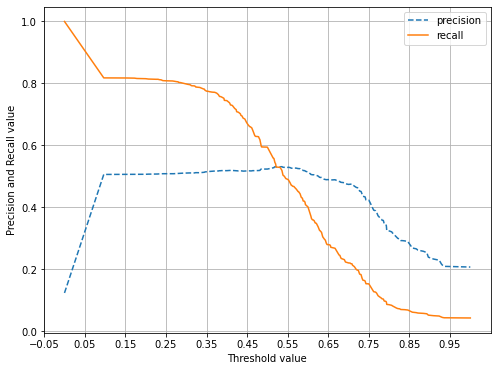

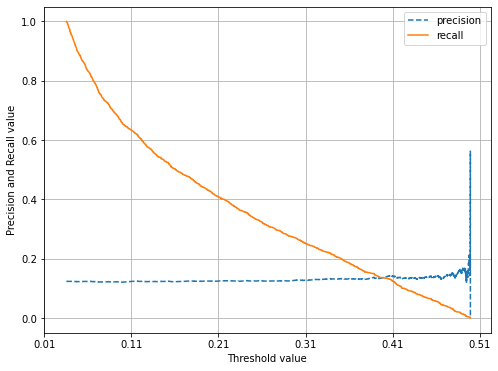

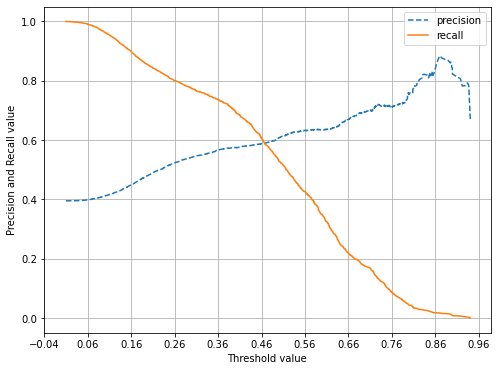

In [66]:
# Plot Function
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # Extarct ndarray of threshold and ndarray of precision, recall by itself
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # Set X axis for threshold values, Y axis for precision, recall and create plot
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    # Scaling threshold values of 0.1 units on X axis
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # Set labels of X axis, y axis, legend and grid
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

# DecisionTreeClassifier
precision_recall_curve_plot(y_test, dt_pred_proba)
# LogisitcRegression
precision_recall_curve_plot(y_test, lr_pred_proba)
# RandomForestClassifier
precision_recall_curve_plot(y_test, rf_pred_proba)

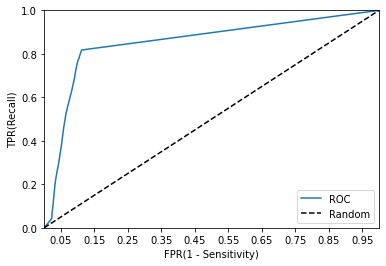

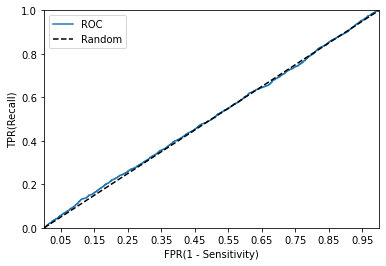

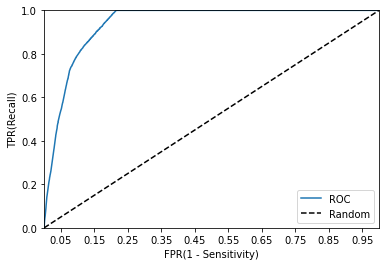

In [67]:
# Plot Function

def roc_curve_plot(y_test, pred_proba_c1):
    # Return values of FPR, TPR by thresholds
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # Plot ROC curve
    plt.plot(fprs, tprs, label='ROC')
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # Scaling threshold values of 0.1 units on X axis(FPR)
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    # Set label of X, Y axis
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()

    plt.show()

roc_curve_plot(y_test, dt_pred_proba)
roc_curve_plot(y_test, lr_pred_proba)
roc_curve_plot(y_test, rf_pred_proba)


### Summary
1. The performance with RandomForestClassifier was much better than other algorithms.
2. As you can see the last plot, we could set threshold value as 0.3 for custom.

In [70]:
# Evaluation with custom threshold value
# Set threshold value as 0.46
custom_threshold = 0.46

# Extract 'Positive Class' in order to apply Binarizer
custom_pred_proba = rf_pred_proba.reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(custom_pred_proba)
custom_predict = binarizer.transform(custom_pred_proba)

get_clf_eval(y_test, custom_predict, custom_pred_proba)

Confusion Matrix
[[41572  2629]
 [ 2446  3753]]
Accuracy: 0.8993, Precision: 0.5881, Recall 0.6054, F1: 0.5966, AUC:0.9391


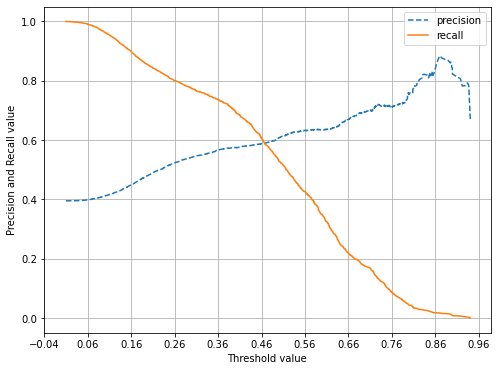

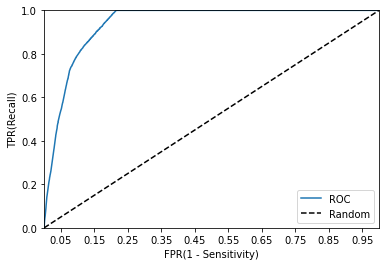

In [71]:
# Plot
precision_recall_curve_plot(y_test, custom_pred_proba)
roc_curve_plot(y_test, custom_pred_proba)

## Classification

### DecisionTreeClassifier

In [68]:
# Re-check for the accuracy score by DecisionTreeClassifier
# Extract hyperparmeters of DecisionTreeClassifier
print('Accuracy Score by DecisionTreeClassifier: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('Hyperparameters of DecisionTreeClassifier:\n', dt_clf.get_params())

Accuracy Score by DecisionTreeClassifier: 0.8841
Hyperparameters of DecisionTreeClassifier:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [77]:
# Tuning of hyperparameters by GridSearchCV
params = {
    'max_depth' : range(10, 30, 5),
    'min_samples_split' : range(20, 40, 10)
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=7, verbose=1, n_jobs=-1, refit=True)
grid_cv.fit(X_train, y_train)
print('The Best Average of Accuracy Scores by GridSearchCV: {0:.4f}'.format(grid_cv.best_score_))
print('The Best Parameters for Optimization: ', grid_cv.best_params_)

Fitting 7 folds for each of 8 candidates, totalling 56 fits
The Best Average of Accuracy Scores by GridSearchCV: 0.8895
The Best Parameters for Optimization:  {'max_depth': 25, 'min_samples_split': 20}


In [78]:
# Create DataFarme with results of GridSearchCv
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['rank_test_score', 'param_max_depth', 'param_min_samples_split', 'mean_test_score']]

,rank_test_score,param_max_depth,param_min_samples_split,mean_test_score
0,7,10,20,0.880451
1,8,10,30,0.880422
2,5,15,20,0.884737
3,6,15,30,0.884439
4,3,20,20,0.888051
5,4,20,30,0.887827
6,1,25,20,0.889514
7,2,25,30,0.889067


In [79]:
best_dt_clf = grid_cv.best_estimator_
best_pred = best_dt_clf.predict(X_test)
best_accuracy = accuracy_score(y_test, best_pred)
print('Accuracy Score of DecisionTreeClassifier: {0:.4f}'.format(best_accuracy))

Accuracy Score of DecisionTreeClassifier: 0.8910


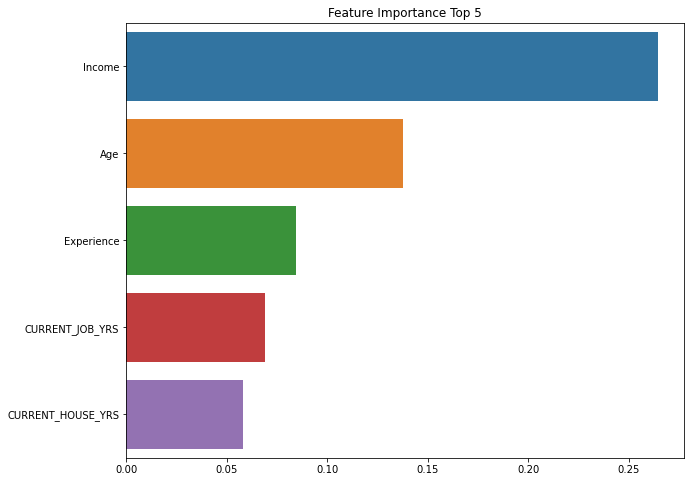

In [82]:
ftr_values = best_dt_clf.feature_importances_
ftr_values = pd.Series(ftr_values, index=X_train.columns)
ftr_top5 = ftr_values.sort_values(ascending=False)[:5]

plt.figure(figsize=(10, 8))
plt.title('Feature Importance Top 5')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()

### Ensemble Learning(Voting Classifier)

In [87]:
# We have already created DeicisonTreeClassifier model above
knn_clf = KNeighborsClassifier(n_neighbors=8)

# Create VotingClassifier by soft voting
vo_clf = VotingClassifier(estimators=[('DT', dt_clf), ('KNN', knn_clf)], voting='soft')

# Fitting, Prediction and Evaluation of VotingClassifier
vo_clf.fit(X_train, y_train)
vo_pred = vo_clf.predict(X_test)
print('Accuracy Score of VotingClassifier: {0:.4f}'.format(accuracy_score(y_test, vo_pred)))

Accuracy Score of VotingClassifier: 0.8904


In [92]:
# Fitting, Prediction and Evalution by each model
classifiers = [dt_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('Accuracy Score of {0}: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Accuracy of DecisionTreeClassifier: 0.8841
Accuracy of KNeighborsClassifier: 0.8918


### Random Forest

### GBM(Gradient Boosting Machine)